# Phase 3: A Deeper Investigation - Probing the Specialist Model for Bias

**Objective:** Before attempting to solve the domain generalization problem, this phase performs a crucial fairness audit on the Specialist Model we developed. The goal is to investigate whether the model exhibits performance differences based on speaker gender, a critical step in responsible AI development.

In [1]:
# --- Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive')

# --- Install All Necessary Packages ---
!pip install librosa resampy praat-parselmouth audiomentations

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 119.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.5/86.5 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.4/109.4 kB 10.4 MB/s eta 0:00:00


In [2]:
# --- This script creates the pre-computed spectrograms for RAVDESS ---
import os
import librosa
import numpy as np
from tqdm import tqdm

# --- Configuration ---
AUDIO_PATH = "/content/drive/MyDrive/ser_project/ravdess_data/"
SPECTROGRAM_PATH = "/content/drive/MyDrive/ser_project/ravdess_spectrograms/"
os.makedirs(SPECTROGRAM_PATH, exist_ok=True)

print("Starting audio to spectrogram conversion for RAVDESS...")
actor_folders = [f for f in os.listdir(AUDIO_PATH) if os.path.isdir(os.path.join(AUDIO_PATH, f))]
for actor_folder in tqdm(actor_folders, desc="Processing RAVDESS Actors"):
    actor_path = os.path.join(AUDIO_PATH, actor_folder)
    for file_name in os.listdir(actor_path):
        try:
            file_path = os.path.join(actor_path, file_name)
            audio, sr = librosa.load(file_path, res_type='kaiser_fast', duration=3, sr=22050*2, offset=0.5)
            spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128, fmax=8000)
            db_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
            output_filename = os.path.join(SPECTROGRAM_PATH, f"{os.path.splitext(file_name)[0]}.npy")
            np.save(output_filename, db_spectrogram)
        except Exception as e:
            print(f"\nError processing {file_path}: {e}")

print("\nRAVDESS spectrogram conversion complete.")

Starting audio to spectrogram conversion for RAVDESS...


Processing RAVDESS Actors: 100%|██████████| 24/24 [09:50<00:00, 24.59s/it]


RAVDESS spectrogram conversion complete.


## Part 1: Re-establishing a Consistent Specialist Model

To ensure our analysis is reliable, we first re-train our robust Specialist Model using the exact same methodology as in Phase 2 (on-the-fly augmentation and early stopping). This provides a consistent and high-performing model to serve as the subject for our bias audit.

In [3]:
# --- This script trains the main ResNet18 model with augmentation and early stopping ---
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import os, numpy as np, librosa
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from torchvision import models
from audiomentations import Compose, AddGaussianNoise, PitchShift

# --- Configuration ---
AUDIO_PATH = "/content/drive/MyDrive/ser_project/ravdess_data/"
LEARNING_RATE = 0.001; BATCH_SIZE = 32; EPOCHS = 30
CHECKPOINT_BEST_PATH = "/content/drive/MyDrive/ser_project/resnet_best_augmented.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Mappings and Augmenter ---
emotion_map = { "01": 0, "02": 1, "03": 2, "04": 3, "05": 4, "06": 5, "07": 6, "08": 7 }
emotion_labels_list = ["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprise"]
augmenter = Compose([AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.4), PitchShift(min_semitones=-4, max_semitones=4, p=0.4)])

# --- Dataset for On-the-Fly Augmentation ---
class AudioDataset(Dataset):
    def __init__(self, file_paths, labels, target_width=300, augment=False):
        self.file_paths = file_paths; self.labels = labels
        self.target_width = target_width; self.augment = augment
    def __len__(self): return len(self.file_paths)
    def __getitem__(self, idx):
        file_path = self.file_paths[idx]; label = self.labels[idx]
        audio, sr = librosa.load(file_path, res_type='kaiser_fast', duration=3, sr=22050*2, offset=0.5)
        if self.augment: audio = augmenter(samples=audio, sample_rate=sr)
        spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128, fmax=8000)
        db_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
        current_width = db_spectrogram.shape[1]
        if current_width < self.target_width: db_spectrogram = np.pad(db_spectrogram, ((0, 0), (0, self.target_width - current_width)), mode='constant')
        elif current_width > self.target_width: db_spectrogram = db_spectrogram[:, :self.target_width]
        spec_min, spec_max = db_spectrogram.min(), db_spectrogram.max()
        if spec_max > spec_min: db_spectrogram = (db_spectrogram - spec_min) / (spec_max - spec_min)
        spectrogram_3ch = np.stack([db_spectrogram, db_spectrogram, db_spectrogram], axis=0)
        return torch.tensor(spectrogram_3ch, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

# --- Prepare Data ---
all_files = []; all_labels = []
for root, dirs, files in os.walk(AUDIO_PATH):
    for file in files:
        if file.endswith('.wav'): all_files.append(os.path.join(root, file))
all_labels = [emotion_map[os.path.basename(f).split("-")[2]] for f in all_files]
train_files, temp_files, train_labels, temp_labels = train_test_split(all_files, all_labels, test_size=0.2, random_state=42, stratify=all_labels)
val_files, test_files, val_labels, test_labels = train_test_split(temp_files, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels)
train_dataset = AudioDataset(train_files, train_labels, augment=True)
val_dataset = AudioDataset(val_files, val_labels, augment=False)
test_dataset = AudioDataset(test_files, test_labels, augment=False)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True); val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False); test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# --- Initialize Model and Optimizer ---
model = models.resnet18(weights='IMAGENET1K_V1'); model.fc = nn.Linear(model.fc.in_features, len(emotion_labels_list)); model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE); criterion = nn.CrossEntropyLoss(); scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

# --- Training Loop with Early Stopping ---
best_val_acc = 0.0
print("Starting main training with augmentation and early stopping...")
for epoch in range(EPOCHS):
    model.train(); running_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad(); outputs = model(inputs); loss = criterion(outputs, labels)
        loss.backward(); optimizer.step(); running_loss += loss.item() * inputs.size(0)
    train_loss = running_loss / len(train_dataset)

    model.eval(); val_loss = 0.0; correct = 0; total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs); loss = criterion(outputs, labels); val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1); total += labels.size(0); correct += (predicted == labels).sum().item()
    val_accuracy = 100 * correct / total; val_loss /= len(val_dataset)
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        print(f"🎉 New best validation accuracy: {best_val_acc:.2f}%. Saving model...")
        torch.save({'epoch': epoch + 1, 'model_state_dict': model.state_dict()}, CHECKPOINT_BEST_PATH)
    scheduler.step()

# --- Final Evaluation on Test Set ---
print("\n--- FINAL EVALUATION ON RAVDESS TEST SET ---")
print(f"Loading best model from epoch with accuracy: {best_val_acc:.2f}%")
best_checkpoint = torch.load(CHECKPOINT_BEST_PATH); model.load_state_dict(best_checkpoint['model_state_dict']); model.eval()
all_preds = []; all_true = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs); _, preds = torch.max(outputs, 1); all_preds.extend(preds.cpu().numpy()); all_true.extend(labels.cpu().numpy())
accuracy = accuracy_score(all_true, all_preds)
print(f"Final Model Accuracy on Test Set: {accuracy * 100:.2f}%")
print("\nClassification Report:"); print(classification_report(all_true, all_preds, target_names=emotion_labels_list, zero_division=0))

Using device: cuda
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 180MB/s]


Starting main training with augmentation and early stopping...


Epoch 1/30 [Val]: 100%|██████████| 5/5 [00:11<00:00,  2.22s/it]


Epoch 1/30 | Train Loss: 1.6532 | Val Loss: 2.8823 | Val Acc: 37.50%
🎉 New best validation accuracy: 37.50%. Saving model...


Epoch 2/30 [Val]: 100%|██████████| 5/5 [00:10<00:00,  2.11s/it]


Epoch 2/30 | Train Loss: 1.2781 | Val Loss: 1.2296 | Val Acc: 56.94%
🎉 New best validation accuracy: 56.94%. Saving model...


Epoch 3/30 [Val]: 100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


Epoch 3/30 | Train Loss: 1.0166 | Val Loss: 2.9642 | Val Acc: 29.86%


Epoch 4/30 [Val]: 100%|██████████| 5/5 [00:10<00:00,  2.13s/it]


Epoch 4/30 | Train Loss: 0.9587 | Val Loss: 2.2445 | Val Acc: 47.22%


Epoch 5/30 [Val]: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


Epoch 5/30 | Train Loss: 0.8055 | Val Loss: 1.3951 | Val Acc: 60.42%
🎉 New best validation accuracy: 60.42%. Saving model...


Epoch 6/30 [Val]: 100%|██████████| 5/5 [00:11<00:00,  2.20s/it]


Epoch 6/30 | Train Loss: 0.6904 | Val Loss: 0.9537 | Val Acc: 63.19%
🎉 New best validation accuracy: 63.19%. Saving model...


Epoch 7/30 [Val]: 100%|██████████| 5/5 [00:09<00:00,  1.97s/it]


Epoch 7/30 | Train Loss: 0.5786 | Val Loss: 1.1922 | Val Acc: 68.06%
🎉 New best validation accuracy: 68.06%. Saving model...


Epoch 8/30 [Val]: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 8/30 | Train Loss: 0.3844 | Val Loss: 0.7905 | Val Acc: 75.69%
🎉 New best validation accuracy: 75.69%. Saving model...


Epoch 9/30 [Val]: 100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


Epoch 9/30 | Train Loss: 0.2794 | Val Loss: 0.7666 | Val Acc: 76.39%
🎉 New best validation accuracy: 76.39%. Saving model...


Epoch 10/30 [Val]: 100%|██████████| 5/5 [00:10<00:00,  2.13s/it]


Epoch 10/30 | Train Loss: 0.2363 | Val Loss: 0.7255 | Val Acc: 74.31%


Epoch 11/30 [Val]: 100%|██████████| 5/5 [00:11<00:00,  2.23s/it]


Epoch 11/30 | Train Loss: 0.1935 | Val Loss: 0.7313 | Val Acc: 76.39%


Epoch 12/30 [Val]: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 12/30 | Train Loss: 0.1786 | Val Loss: 0.7641 | Val Acc: 74.31%


Epoch 13/30 [Val]: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


Epoch 13/30 | Train Loss: 0.1883 | Val Loss: 0.7037 | Val Acc: 78.47%
🎉 New best validation accuracy: 78.47%. Saving model...


Epoch 14/30 [Val]: 100%|██████████| 5/5 [00:11<00:00,  2.22s/it]


Epoch 14/30 | Train Loss: 0.1626 | Val Loss: 0.7451 | Val Acc: 75.69%


Epoch 15/30 [Val]: 100%|██████████| 5/5 [00:10<00:00,  2.02s/it]


Epoch 15/30 | Train Loss: 0.1371 | Val Loss: 0.7452 | Val Acc: 76.39%


Epoch 16/30 [Val]: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 16/30 | Train Loss: 0.1192 | Val Loss: 0.7403 | Val Acc: 77.08%


Epoch 17/30 [Val]: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 17/30 | Train Loss: 0.1137 | Val Loss: 0.7448 | Val Acc: 75.00%


Epoch 18/30 [Val]: 100%|██████████| 5/5 [00:09<00:00,  1.93s/it]


Epoch 18/30 | Train Loss: 0.1094 | Val Loss: 0.7508 | Val Acc: 77.08%


Epoch 19/30 [Val]: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 19/30 | Train Loss: 0.1202 | Val Loss: 0.7248 | Val Acc: 77.08%


Epoch 20/30 [Val]: 100%|██████████| 5/5 [00:10<00:00,  2.18s/it]


Epoch 20/30 | Train Loss: 0.0974 | Val Loss: 0.7409 | Val Acc: 76.39%


Epoch 21/30 [Val]: 100%|██████████| 5/5 [00:10<00:00,  2.12s/it]


Epoch 21/30 | Train Loss: 0.1217 | Val Loss: 0.7103 | Val Acc: 77.08%


Epoch 22/30 [Val]: 100%|██████████| 5/5 [00:10<00:00,  2.15s/it]


Epoch 22/30 | Train Loss: 0.1271 | Val Loss: 0.7356 | Val Acc: 75.69%


Epoch 23/30 [Val]: 100%|██████████| 5/5 [00:09<00:00,  1.80s/it]


Epoch 23/30 | Train Loss: 0.1022 | Val Loss: 0.7371 | Val Acc: 76.39%


Epoch 24/30 [Val]: 100%|██████████| 5/5 [00:10<00:00,  2.17s/it]


Epoch 24/30 | Train Loss: 0.1222 | Val Loss: 0.7298 | Val Acc: 77.08%


Epoch 25/30 [Val]: 100%|██████████| 5/5 [00:10<00:00,  2.15s/it]


Epoch 25/30 | Train Loss: 0.1040 | Val Loss: 0.7281 | Val Acc: 75.69%


Epoch 26/30 [Val]: 100%|██████████| 5/5 [00:10<00:00,  2.16s/it]


Epoch 26/30 | Train Loss: 0.1051 | Val Loss: 0.7417 | Val Acc: 76.39%


Epoch 27/30 [Val]: 100%|██████████| 5/5 [00:10<00:00,  2.14s/it]


Epoch 27/30 | Train Loss: 0.1072 | Val Loss: 0.7309 | Val Acc: 76.39%


Epoch 28/30 [Val]: 100%|██████████| 5/5 [00:10<00:00,  2.19s/it]


Epoch 28/30 | Train Loss: 0.1145 | Val Loss: 0.7475 | Val Acc: 75.69%


Epoch 29/30 [Val]: 100%|██████████| 5/5 [00:10<00:00,  2.14s/it]


Epoch 29/30 | Train Loss: 0.0920 | Val Loss: 0.7229 | Val Acc: 78.47%


Epoch 30/30 [Val]: 100%|██████████| 5/5 [00:09<00:00,  1.97s/it]


Epoch 30/30 | Train Loss: 0.1120 | Val Loss: 0.7147 | Val Acc: 77.08%

--- FINAL EVALUATION ON RAVDESS TEST SET ---
Loading best model from epoch with accuracy: 78.47%
Final Model Accuracy on Test Set: 79.86%

Classification Report:
              precision    recall  f1-score   support

     neutral       0.56      0.50      0.53        10
        calm       0.82      0.74      0.78        19
       happy       0.88      0.79      0.83        19
         sad       0.58      0.79      0.67        19
       angry       0.85      0.89      0.87        19
     fearful       0.88      0.70      0.78        20
     disgust       0.94      0.89      0.92        19
    surprise       0.86      0.95      0.90        19

    accuracy                           0.80       144
   macro avg       0.80      0.78      0.78       144
weighted avg       0.81      0.80      0.80       144



## Part 2: Gender Bias Analysis

This is the core contribution of this notebook. We take the test set predictions from our re-trained Specialist Model and analyze them based on speaker gender. The RAVDESS dataset's file naming convention (odd-numbered actors are male, even-numbered are female) allows us to perform this split. We calculate separate accuracy scores and generate individual confusion matrices to visually inspect the model's error patterns for each group.

Using device: cuda
Recreating the test set to ensure consistency...
Test set successfully recreated.
Loading best model and running predictions on the test set...


Predicting: 100%|██████████| 5/5 [00:09<00:00,  1.88s/it]


Labeling test data by speaker gender...

--- GENDER-BASED PERFORMANCE ANALYSIS ---
Accuracy for Male Speakers: 80.88% (68 samples)
Accuracy for Female Speakers: 78.95% (76 samples)

Generating confusion matrices...


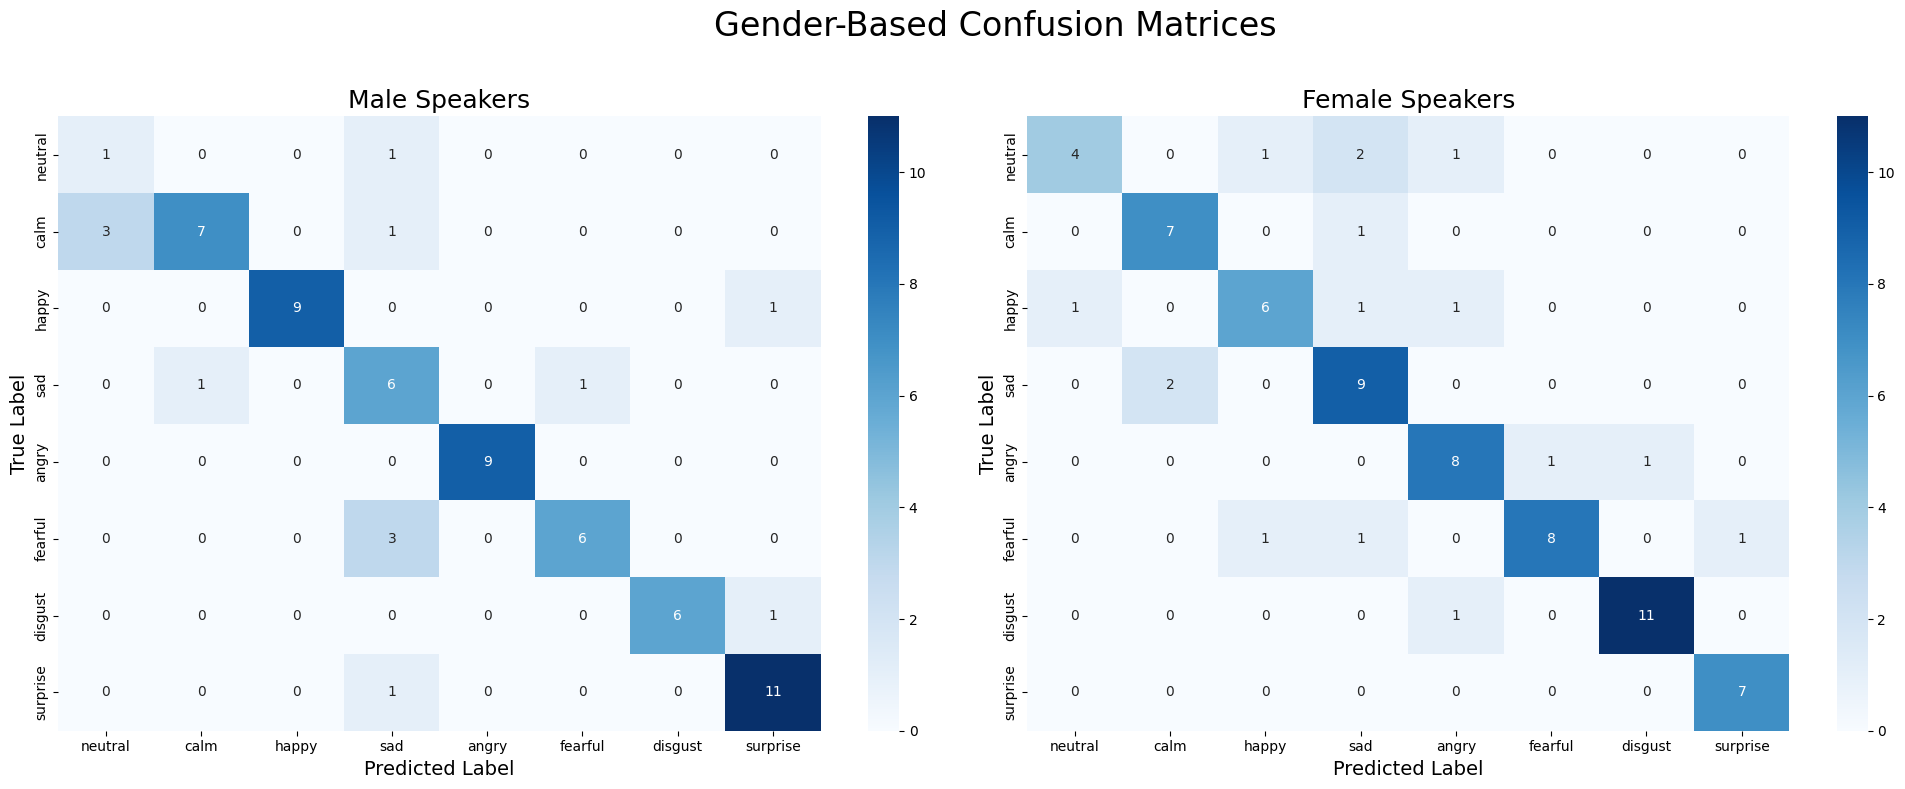

In [4]:
import torch
import torch.nn as nn
from torchvision import models
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import librosa

# --- Configuration ---
CHECKPOINT_BEST_PATH = "/content/drive/MyDrive/ser_project/resnet_best_augmented.pth"
AUDIO_PATH = "/content/drive/MyDrive/ser_project/ravdess_data/" # Needed to get file list
BATCH_SIZE = 32

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Mappings ---
emotion_map = { "01": 0, "02": 1, "03": 2, "04": 3, "05": 4, "06": 5, "07": 6, "08": 7 }
emotion_labels_list = ["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprise"]

# --- IMPORTANT: We need the AudioDataset class definition to load our data ---
class AudioDataset(Dataset):
    def __init__(self, file_paths, labels, target_width=300, augment=False):
        self.file_paths = file_paths; self.labels = labels
        self.target_width = target_width; self.augment = augment
    def __len__(self): return len(self.file_paths)
    def __getitem__(self, idx):
        file_path = self.file_paths[idx]; label = self.labels[idx]
        audio, sr = librosa.load(file_path, res_type='kaiser_fast', duration=3, sr=22050*2, offset=0.5)
        # Note: No augmentation during evaluation
        spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128, fmax=8000)
        db_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
        current_width = db_spectrogram.shape[1]
        if current_width < self.target_width: db_spectrogram = np.pad(db_spectrogram, ((0, 0), (0, self.target_width - current_width)), mode='constant')
        elif current_width > self.target_width: db_spectrogram = db_spectrogram[:, :self.target_width]
        spec_min, spec_max = db_spectrogram.min(), db_spectrogram.max()
        if spec_max > spec_min: db_spectrogram = (db_spectrogram - spec_min) / (spec_max - spec_min)
        spectrogram_3ch = np.stack([db_spectrogram, db_spectrogram, db_spectrogram], axis=0)
        return torch.tensor(spectrogram_3ch, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

# --- Step 1: Recreate the exact same test set split ---
print("Recreating the test set to ensure consistency...")
all_files = []; all_labels = []
for root, dirs, files in os.walk(AUDIO_PATH):
    for file in files:
        if file.endswith('.wav'): all_files.append(os.path.join(root, file))
all_labels = [emotion_map[os.path.basename(f).split("-")[2]] for f in all_files]

# We use the same test_size and random_state to get the identical split
train_files, temp_files, train_labels, temp_labels = train_test_split(all_files, all_labels, test_size=0.2, random_state=42, stratify=all_labels)
val_files, test_files, val_labels, test_labels = train_test_split(temp_files, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels)

test_dataset = AudioDataset(test_files, test_labels, augment=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
print("Test set successfully recreated.")

# --- Step 2: Load Model and Run Predictions ---
print("Loading best model and running predictions on the test set...")
model = models.resnet18(); model.fc = nn.Linear(model.fc.in_features, len(emotion_labels_list));
best_checkpoint = torch.load(CHECKPOINT_BEST_PATH); model.load_state_dict(best_checkpoint['model_state_dict']);
model = model.to(device); model.eval()

all_preds = []; all_true = []
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Predicting"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs); _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy()); all_true.extend(labels.cpu().numpy())

# --- Step 3: Label Data by Gender ---
print("Labeling test data by speaker gender...")
results = []
for i in range(len(test_files)):
    file_path = test_files[i]
    actor_id = int(os.path.basename(file_path).split("-")[6].split(".")[0])
    gender = "female" if actor_id % 2 == 0 else "male"
    results.append({
        'true_label': emotion_labels_list[all_true[i]],
        'predicted_label': emotion_labels_list[all_preds[i]],
        'gender': gender
    })
df = pd.DataFrame(results)

# --- Step 4: Analyze Performance ---
print("\n--- GENDER-BASED PERFORMANCE ANALYSIS ---")
male_df = df[df['gender'] == 'male']; female_df = df[df['gender'] == 'female']
male_accuracy = accuracy_score(male_df['true_label'], male_df['predicted_label'])
female_accuracy = accuracy_score(female_df['true_label'], female_df['predicted_label'])
print(f"Accuracy for Male Speakers: {male_accuracy * 100:.2f}% ({len(male_df)} samples)")
print(f"Accuracy for Female Speakers: {female_accuracy * 100:.2f}% ({len(female_df)} samples)")

# --- Step 5: Visualize the Bias ---
print("\nGenerating confusion matrices...")
fig, axes = plt.subplots(1, 2, figsize=(20, 8)); fig.suptitle('Gender-Based Confusion Matrices', fontsize=24)
cm_male = confusion_matrix(male_df['true_label'], male_df['predicted_label'], labels=emotion_labels_list)
sns.heatmap(cm_male, annot=True, fmt='d', xticklabels=emotion_labels_list, yticklabels=emotion_labels_list, ax=axes[0], cmap='Blues')
axes[0].set_title('Male Speakers', fontsize=18); axes[0].set_xlabel('Predicted Label', fontsize=14); axes[0].set_ylabel('True Label', fontsize=14)
cm_female = confusion_matrix(female_df['true_label'], female_df['predicted_label'], labels=emotion_labels_list)
sns.heatmap(cm_female, annot=True, fmt='d', xticklabels=emotion_labels_list, yticklabels=emotion_labels_list, ax=axes[1], cmap='Blues')
axes[1].set_title('Female Speakers', fontsize=18); axes[1].set_xlabel('Predicted Label', fontsize=14); axes[1].set_ylabel('True Label', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96]); plt.show()

## Part 3: Re-confirming the Domain Gap

In [5]:
# --- This cell tests the best model on the CREMA-D dataset ---
# Make sure you have uploaded and unzipped CREMA-D to this path
CREMA_D_AUDIO_PATH = "/content/drive/MyDrive/ser_project/crema_d_data/AudioWAV/"
CREMA_D_SPECTROGRAM_PATH = "/content/drive/MyDrive/ser_project/crema_d_spectrograms/"
CHECKPOINT_BEST_PATH = "/content/drive/MyDrive/ser_project/resnet_best_augmented.pth"

# === PART A: PREPROCESS CREMA-D ===
os.makedirs(CREMA_D_SPECTROGRAM_PATH, exist_ok=True)
print("\nStarting audio to spectrogram conversion for CREMA-D...")
crema_d_files_to_process = [f for f in os.listdir(CREMA_D_AUDIO_PATH) if f.endswith('.wav')]
for file_name in tqdm(crema_d_files_to_process, desc="Processing CREMA-D"):
    try:
        file_path = os.path.join(CREMA_D_AUDIO_PATH, file_name)
        audio, sr = librosa.load(file_path, res_type='kaiser_fast', duration=3, sr=22050*2, offset=0.5)
        spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128, fmax=8000)
        db_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
        output_filename = os.path.join(CREMA_D_SPECTROGRAM_PATH, f"{os.path.splitext(file_name)[0]}.npy")
        np.save(output_filename, db_spectrogram)
    except Exception as e:
        print(f"\nError processing {file_path}: {e}")
print("\nCREMA-D spectrogram conversion complete.")

# === PART B: EVALUATE ON CREMA-D ===
# --- Mappings and Dataset ---
crema_d_emotion_map = { "NEU": 0, "HAP": 2, "SAD": 3, "ANG": 4, "FEA": 5, "DIS": 6 }
# Note: We are mapping to the original 8-class indices that the model was trained on
class CremaDDataset(Dataset):
    def __init__(self, file_paths, labels, target_width=300):
        self.file_paths, self.labels, self.target_width = file_paths, labels, target_width
    def __len__(self): return len(self.file_paths)
    def __getitem__(self, idx):
        spectrogram = np.load(self.file_paths[idx]); label = self.labels[idx]
        current_width = spectrogram.shape[1]
        if current_width < self.target_width: spectrogram = np.pad(spectrogram, ((0, 0), (0, self.target_width - current_width)), mode='constant')
        elif current_width > self.target_width: spectrogram = spectrogram[:, :self.target_width]
        spec_min, spec_max = spectrogram.min(), spectrogram.max()
        if spec_max > spec_min: spectrogram = (spectrogram - spec_min) / (spec_max - spec_min)
        spectrogram_3ch = np.stack([spectrogram, spectrogram, spectrogram], axis=0)
        return torch.tensor(spectrogram_3ch, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

crema_d_files = [os.path.join(CREMA_D_SPECTROGRAM_PATH, f) for f in os.listdir(CREMA_D_SPECTROGRAM_PATH) if f.endswith('.npy')]
crema_d_labels = [crema_d_emotion_map[os.path.basename(f).split("_")[2]] for f in crema_d_files]
test_dataset = CremaDDataset(crema_d_files, crema_d_labels)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# --- Load Model and Evaluate ---
print("\nLoading best model for cross-corpus evaluation...")
model = models.resnet18(); model.fc = nn.Linear(model.fc.in_features, 8);
best_checkpoint = torch.load(CHECKPOINT_BEST_PATH); model.load_state_dict(best_checkpoint['model_state_dict']); model = model.to(device); model.eval()
print("\n--- EVALUATION ON CREMA-D DATASET ---")
all_preds, all_true = [], []
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Evaluating on CREMA-D"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs); _, preds = torch.max(outputs, 1); all_preds.extend(preds.cpu().numpy()); all_true.extend(labels.cpu().numpy())
accuracy = accuracy_score(all_true, all_preds)
print(f"Final Model Accuracy on CREMA-D: {accuracy * 100:.2f}%")
report_labels_indices = sorted(list(set(crema_d_labels))); report_labels_names = [emotion_labels_list[i] for i in report_labels_indices]
print("\nClassification Report:"); print(classification_report(all_true, all_preds, labels=report_labels_indices, target_names=report_labels_names, zero_division=0))


Starting audio to spectrogram conversion for CREMA-D...


Processing CREMA-D: 100%|██████████| 7442/7442 [10:17<00:00, 12.05it/s]



CREMA-D spectrogram conversion complete.

Loading best model for cross-corpus evaluation...

--- EVALUATION ON CREMA-D DATASET ---


Evaluating on CREMA-D: 100%|██████████| 233/233 [01:46<00:00,  2.19it/s]

Final Model Accuracy on CREMA-D: 23.85%

Classification Report:
              precision    recall  f1-score   support

     neutral       0.49      0.07      0.13      1087
       happy       0.23      0.04      0.06      1271
         sad       0.25      0.46      0.32      1271
       angry       0.67      0.13      0.22      1271
     fearful       0.24      0.54      0.34      1271
     disgust       0.44      0.17      0.25      1271

   micro avg       0.28      0.24      0.26      7442
   macro avg       0.39      0.23      0.22      7442
weighted avg       0.39      0.24      0.22      7442



## Part 4: Re-confirming the Failure of Distillation From Phase-02

In [6]:
# --- This script trains a small 'student' CNN using the large 'teacher' ResNet18 ---
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import os, numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torchvision import models

# --- Configuration ---
SPECTROGRAM_PATH = "/content/drive/MyDrive/ser_project/ravdess_spectrograms/"
TEACHER_CHECKPOINT_PATH = "/content/drive/MyDrive/ser_project/resnet_best_augmented.pth"
STUDENT_CHECKPOINT_PATH = "/content/drive/MyDrive/ser_project/student_cnn_distilled.pth"
LEARNING_RATE = 0.005; BATCH_SIZE = 32; EPOCHS = 50
TEMPERATURE = 4.0; ALPHA = 0.3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu"); print(f"Using device: {device}")

# --- Mappings and Dataset (using pre-computed spectrograms for speed) ---
emotion_map = { "01": 0, "02": 1, "03": 2, "04": 3, "05": 4, "06": 5, "07": 6, "08": 7 }
emotion_labels_list = ["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprise"]
class SpectrogramDataset(Dataset):
    def __init__(self, file_paths, labels, target_width=300):
        self.file_paths, self.labels, self.target_width = file_paths, labels, target_width
    def __len__(self): return len(self.file_paths)
    def __getitem__(self, idx):
        spectrogram = np.load(self.file_paths[idx]); label = self.labels[idx]
        current_width = spectrogram.shape[1]
        if current_width < self.target_width: spectrogram = np.pad(spectrogram, ((0, 0), (0, self.target_width - current_width)), mode='constant')
        elif current_width > self.target_width: spectrogram = spectrogram[:, :self.target_width]
        spec_min, spec_max = spectrogram.min(), spectrogram.max()
        if spec_max > spec_min: spectrogram = (spectrogram - spec_min) / (spec_max - spec_min)
        spectrogram_3ch = np.stack([spectrogram, spectrogram, spectrogram], axis=0)
        return torch.tensor(spectrogram_3ch, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

# --- Student Model Definition (AudioCNN Modified for 3-Channel Input) ---
class AudioCNN(nn.Module):
    def __init__(self, num_classes=8, flattened_size=9216):
        super(AudioCNN, self).__init__(); self.conv1 = nn.Conv2d(3, 16, 3, 1, 1); self.bn1 = nn.BatchNorm2d(16); self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1); self.bn2 = nn.BatchNorm2d(32); self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, 1); self.bn3 = nn.BatchNorm2d(64); self.pool3 = nn.MaxPool2d(4, 4)
        self.flatten = nn.Flatten(); self.fc1 = nn.Linear(flattened_size, 128); self.dropout = nn.Dropout(0.5); self.fc2 = nn.Linear(128, num_classes)
    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x)))); x = self.pool2(F.relu(self.bn2(self.conv2(x)))); x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.flatten(x); x = F.relu(self.fc1(x)); x = self.dropout(x); x = self.fc2(x); return x

# --- Prepare Data ---
all_files = [os.path.join(SPECTROGRAM_PATH, f) for f in os.listdir(SPECTROGRAM_PATH) if f.endswith('.npy')]
all_labels = [emotion_map[os.path.basename(f).split("-")[2]] for f in all_files]
train_files, test_files, train_labels, test_labels = train_test_split(all_files, all_labels, test_size=0.2, random_state=42, stratify=all_labels)
train_dataset = SpectrogramDataset(train_files, train_labels); test_dataset = SpectrogramDataset(test_files, test_labels)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True); test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# --- Load Teacher Model ---
print("Loading Teacher model (ResNet18)...")
teacher_model = models.resnet18(); teacher_model.fc = nn.Linear(teacher_model.fc.in_features, len(emotion_labels_list))
teacher_checkpoint = torch.load(TEACHER_CHECKPOINT_PATH); teacher_model.load_state_dict(teacher_checkpoint['model_state_dict'])
teacher_model = teacher_model.to(device); teacher_model.eval()

# --- Initialize Student Model ---
print("Initializing Student model (AudioCNN)...")
student_model = AudioCNN(num_classes=8, flattened_size=9216).to(device)

# --- Optimizer and Loss Functions ---
optimizer = torch.optim.Adam(student_model.parameters(), lr=LEARNING_RATE)
criterion_ce = nn.CrossEntropyLoss(); criterion_kd = nn.KLDivLoss(reduction='batchmean')

# --- Distillation Training Loop ---
print("Starting distillation training...")
for epoch in range(EPOCHS):
    student_model.train(); running_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        inputs, labels = inputs.to(device), labels.to(device)
        with torch.no_grad(): teacher_outputs = teacher_model(inputs)
        student_outputs = student_model(inputs)
        loss_ce = criterion_ce(student_outputs, labels)
        soft_teacher = F.softmax(teacher_outputs / TEMPERATURE, dim=1)
        soft_student = F.log_softmax(student_outputs / TEMPERATURE, dim=1)
        loss_kd = criterion_kd(soft_student, soft_teacher)
        loss = ALPHA * loss_ce + (1.0 - ALPHA) * (TEMPERATURE**2) * loss_kd
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_dataset); print(f"Epoch {epoch+1}/{EPOCHS} - Distillation Loss: {epoch_loss:.4f}")

# --- Final Evaluation of Student Model ---
student_model.eval(); all_preds, all_true = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = student_model(inputs); _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy()); all_true.extend(labels.cpu().numpy())
accuracy = accuracy_score(all_true, all_preds)
print(f"\n--- FINAL EVALUATION OF DISTILLED STUDENT MODEL ---")
print(f"Student Model Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:"); print(classification_report(all_true, all_preds, target_names=emotion_labels_list, zero_division=0))

Using device: cuda
Loading Teacher model (ResNet18)...
Initializing Student model (AudioCNN)...
Starting distillation training...


Epoch 1/50: 100%|██████████| 36/36 [00:16<00:00,  2.15it/s]


Epoch 1/50 - Distillation Loss: 12.4701


Epoch 2/50: 100%|██████████| 36/36 [00:05<00:00,  6.07it/s]


Epoch 2/50 - Distillation Loss: 7.1171


Epoch 3/50: 100%|██████████| 36/36 [00:05<00:00,  6.15it/s]


Epoch 3/50 - Distillation Loss: 7.0965


Epoch 4/50: 100%|██████████| 36/36 [00:05<00:00,  6.43it/s]


Epoch 4/50 - Distillation Loss: 7.0792


Epoch 5/50: 100%|██████████| 36/36 [00:05<00:00,  6.27it/s]


Epoch 5/50 - Distillation Loss: 7.0643


Epoch 6/50: 100%|██████████| 36/36 [00:05<00:00,  6.50it/s]


Epoch 6/50 - Distillation Loss: 7.0522


Epoch 7/50: 100%|██████████| 36/36 [00:05<00:00,  6.34it/s]


Epoch 7/50 - Distillation Loss: 7.0429


Epoch 8/50: 100%|██████████| 36/36 [00:05<00:00,  6.37it/s]


Epoch 8/50 - Distillation Loss: 7.0352


Epoch 9/50: 100%|██████████| 36/36 [00:05<00:00,  6.03it/s]


Epoch 9/50 - Distillation Loss: 7.0297


Epoch 10/50: 100%|██████████| 36/36 [00:05<00:00,  6.06it/s]


Epoch 10/50 - Distillation Loss: 7.0253


Epoch 11/50: 100%|██████████| 36/36 [00:05<00:00,  6.34it/s]


Epoch 11/50 - Distillation Loss: 7.0209


Epoch 12/50: 100%|██████████| 36/36 [00:06<00:00,  5.26it/s]


Epoch 12/50 - Distillation Loss: 7.0183


Epoch 13/50: 100%|██████████| 36/36 [00:05<00:00,  6.28it/s]


Epoch 13/50 - Distillation Loss: 7.0160


Epoch 14/50: 100%|██████████| 36/36 [00:05<00:00,  6.20it/s]


Epoch 14/50 - Distillation Loss: 7.0137


Epoch 15/50: 100%|██████████| 36/36 [00:05<00:00,  6.42it/s]


Epoch 15/50 - Distillation Loss: 7.0127


Epoch 16/50: 100%|██████████| 36/36 [00:05<00:00,  6.19it/s]


Epoch 16/50 - Distillation Loss: 7.0116


Epoch 17/50: 100%|██████████| 36/36 [00:05<00:00,  6.34it/s]


Epoch 17/50 - Distillation Loss: 7.0107


Epoch 18/50: 100%|██████████| 36/36 [00:05<00:00,  6.27it/s]


Epoch 18/50 - Distillation Loss: 7.0102


Epoch 19/50: 100%|██████████| 36/36 [00:05<00:00,  6.38it/s]


Epoch 19/50 - Distillation Loss: 7.0093


Epoch 20/50: 100%|██████████| 36/36 [00:05<00:00,  6.11it/s]


Epoch 20/50 - Distillation Loss: 7.0093


Epoch 21/50: 100%|██████████| 36/36 [00:05<00:00,  6.17it/s]


Epoch 21/50 - Distillation Loss: 7.0087


Epoch 22/50: 100%|██████████| 36/36 [00:05<00:00,  6.23it/s]


Epoch 22/50 - Distillation Loss: 7.0086


Epoch 23/50: 100%|██████████| 36/36 [00:05<00:00,  6.20it/s]


Epoch 23/50 - Distillation Loss: 7.0082


Epoch 24/50: 100%|██████████| 36/36 [00:05<00:00,  6.40it/s]


Epoch 24/50 - Distillation Loss: 7.0090


Epoch 25/50: 100%|██████████| 36/36 [00:05<00:00,  6.22it/s]


Epoch 25/50 - Distillation Loss: 7.0078


Epoch 26/50: 100%|██████████| 36/36 [00:05<00:00,  6.28it/s]


Epoch 26/50 - Distillation Loss: 7.0082


Epoch 27/50: 100%|██████████| 36/36 [00:05<00:00,  6.18it/s]


Epoch 27/50 - Distillation Loss: 7.0090


Epoch 28/50: 100%|██████████| 36/36 [00:05<00:00,  6.24it/s]


Epoch 28/50 - Distillation Loss: 7.0085


Epoch 29/50: 100%|██████████| 36/36 [00:05<00:00,  6.27it/s]


Epoch 29/50 - Distillation Loss: 7.0081


Epoch 30/50: 100%|██████████| 36/36 [00:05<00:00,  6.14it/s]


Epoch 30/50 - Distillation Loss: 7.0080


Epoch 31/50: 100%|██████████| 36/36 [00:05<00:00,  6.36it/s]


Epoch 31/50 - Distillation Loss: 7.0084


Epoch 32/50: 100%|██████████| 36/36 [00:05<00:00,  6.28it/s]


Epoch 32/50 - Distillation Loss: 7.0083


Epoch 33/50: 100%|██████████| 36/36 [00:05<00:00,  6.41it/s]


Epoch 33/50 - Distillation Loss: 7.0081


Epoch 34/50: 100%|██████████| 36/36 [00:05<00:00,  6.06it/s]


Epoch 34/50 - Distillation Loss: 7.0077


Epoch 35/50: 100%|██████████| 36/36 [00:05<00:00,  6.33it/s]


Epoch 35/50 - Distillation Loss: 7.0077


Epoch 36/50: 100%|██████████| 36/36 [00:05<00:00,  6.29it/s]


Epoch 36/50 - Distillation Loss: 7.0080


Epoch 37/50: 100%|██████████| 36/36 [00:05<00:00,  6.19it/s]


Epoch 37/50 - Distillation Loss: 7.0079


Epoch 38/50: 100%|██████████| 36/36 [00:06<00:00,  5.99it/s]


Epoch 38/50 - Distillation Loss: 7.0078


Epoch 39/50: 100%|██████████| 36/36 [00:06<00:00,  5.98it/s]


Epoch 39/50 - Distillation Loss: 7.0083


Epoch 40/50: 100%|██████████| 36/36 [00:05<00:00,  6.25it/s]


Epoch 40/50 - Distillation Loss: 7.0078


Epoch 41/50: 100%|██████████| 36/36 [00:06<00:00,  5.89it/s]


Epoch 41/50 - Distillation Loss: 7.0081


Epoch 42/50: 100%|██████████| 36/36 [00:05<00:00,  6.28it/s]


Epoch 42/50 - Distillation Loss: 7.0078


Epoch 43/50: 100%|██████████| 36/36 [00:05<00:00,  6.14it/s]


Epoch 43/50 - Distillation Loss: 7.0081


Epoch 44/50: 100%|██████████| 36/36 [00:05<00:00,  6.31it/s]


Epoch 44/50 - Distillation Loss: 7.0079


Epoch 45/50: 100%|██████████| 36/36 [00:05<00:00,  6.28it/s]


Epoch 45/50 - Distillation Loss: 7.0079


Epoch 46/50: 100%|██████████| 36/36 [00:05<00:00,  6.36it/s]


Epoch 46/50 - Distillation Loss: 7.0080


Epoch 47/50: 100%|██████████| 36/36 [00:05<00:00,  6.29it/s]


Epoch 47/50 - Distillation Loss: 7.0076


Epoch 48/50: 100%|██████████| 36/36 [00:05<00:00,  6.04it/s]


Epoch 48/50 - Distillation Loss: 7.0075


Epoch 49/50: 100%|██████████| 36/36 [00:05<00:00,  6.45it/s]


Epoch 49/50 - Distillation Loss: 7.0082


Epoch 50/50: 100%|██████████| 36/36 [00:05<00:00,  6.11it/s]


Epoch 50/50 - Distillation Loss: 7.0083

--- FINAL EVALUATION OF DISTILLED STUDENT MODEL ---
Student Model Accuracy: 13.19%

Classification Report:
              precision    recall  f1-score   support

     neutral       0.00      0.00      0.00        19
        calm       0.00      0.00      0.00        38
       happy       0.00      0.00      0.00        38
         sad       0.13      1.00      0.23        38
       angry       0.00      0.00      0.00        39
     fearful       0.00      0.00      0.00        39
     disgust       0.00      0.00      0.00        38
    surprise       0.00      0.00      0.00        39

    accuracy                           0.13       288
   macro avg       0.02      0.12      0.03       288
weighted avg       0.02      0.13      0.03       288

